In [ ]:
%load_ext autoreload
%autoreload 2

In [32]:
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import matplotlib.pyplot as plt

CUB-200 Image:
  Path: /gpfs/data/fieremanslab/dayne/projects/DL-Final-Competition/data/Open_Images/0a0aa9e4a5d037e5.jpg
  Size: (682, 1024)
  Mode: RGB

mini-ImageNet Image:
  Path: /gpfs/data/fieremanslab/dayne/projects/DL-Final-Competition/data/mini-ImageNet/train/22393_class042.jpg
  Size: (96, 96)
  Mode: RGB



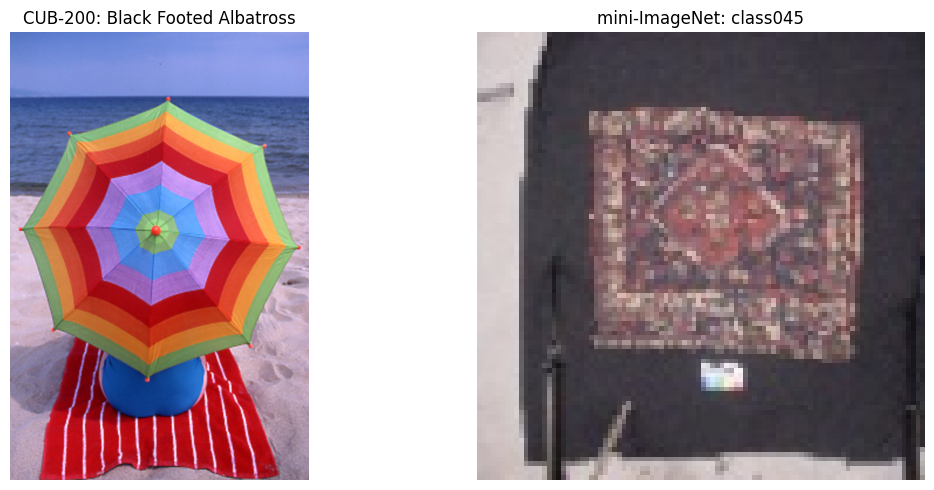

In [42]:
# Load sample images from both datasets
# cub_image_path = '/gpfs/data/fieremanslab/dayne/projects/DL-Final-Competition/data/CUB-200/test/01902_Gray_Crowned_Rosy_Finch_0040_26985.jpg'
cub_image_path = '/gpfs/data/fieremanslab/dayne/projects/DL-Final-Competition/data/Open_Images/0a0aa9e4a5d037e5.jpg'
mini_imagenet_path = '/gpfs/data/fieremanslab/dayne/projects/DL-Final-Competition/data/mini-ImageNet/train/22393_class042.jpg'

# Load CUB-200 image
cub_img = Image.open(cub_image_path)
print(f"CUB-200 Image:")
print(f"  Path: {cub_image_path}")
print(f"  Size: {cub_img.size}")
print(f"  Mode: {cub_img.mode}")
print()

# Load mini-ImageNet image
mini_imagenet_img = Image.open(mini_imagenet_path)
print(f"mini-ImageNet Image:")
print(f"  Path: {mini_imagenet_path}")
print(f"  Size: {mini_imagenet_img.size}")
print(f"  Mode: {mini_imagenet_img.mode}")
print()

# Display both images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(cub_img)
axes[0].set_title('CUB-200: Black Footed Albatross')
axes[0].axis('off')

axes[1].imshow(mini_imagenet_img)
axes[1].set_title('mini-ImageNet: class045')
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [43]:
# Custom transform: resize long edge to 96, pad to square, normalize
class ResizeLongEdgeAndPad:
    def __init__(self, size=96):
        self.size = size

    def __call__(self, img):
        w, h = img.size
        # Resize so long edge = target size
        scale = self.size / max(w, h)
        new_size = (int(w * scale), int(h * scale))
        img = img.resize(new_size, Image.BILINEAR)

        # Pad to square
        pad_w = self.size - new_size[0]
        pad_h = self.size - new_size[1]
        padding = (pad_w // 2, pad_h // 2, pad_w - pad_w // 2, pad_h - pad_h // 2)
        return transforms.functional.pad(img, padding, fill=0)

# Transform matching get_eval_transforms() output
transform = transforms.Compose([
    ResizeLongEdgeAndPad(96),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print(transform)


Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [44]:
def get_eval_transforms():
    """Simple transforms for evaluation (no augmentation)"""
    RESIZE_SIZE = 96    # fixed size for the model input
    return transforms.Compose([
        transforms.Resize(RESIZE_SIZE),  # Resize shorter edge to 96
        transforms.CenterCrop(RESIZE_SIZE),  # Crop to 96x96
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ])

transform2 = get_eval_transforms()

Original CUB-200: (682, 1024)
Transformed: torch.Size([3, 96, 96])

Original mini-ImageNet: (96, 96)
Transformed: torch.Size([3, 96, 96])


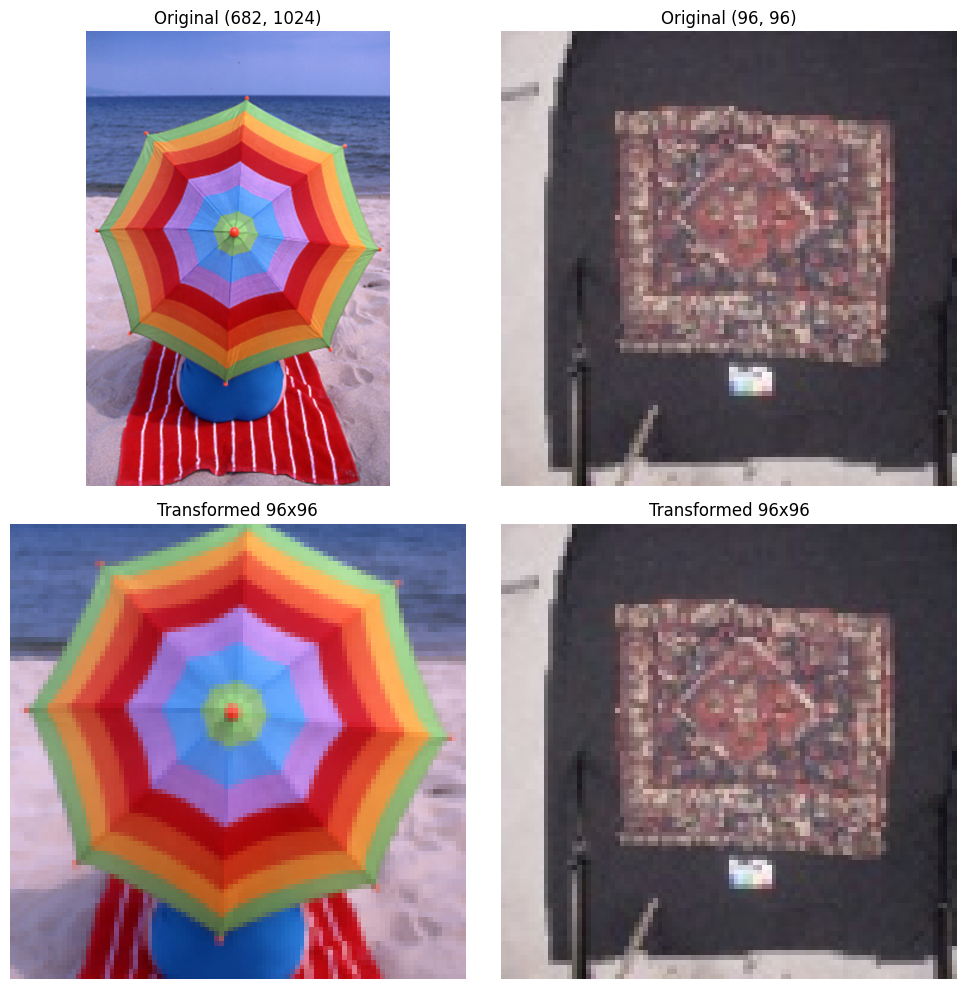

In [45]:
# Apply transform
cub_transformed = transform2(cub_img)
mini_imagenet_transformed = transform2(mini_imagenet_img)

print(f"Original CUB-200: {cub_img.size}")
print(f"Transformed: {cub_transformed.shape}")
print(f"\nOriginal mini-ImageNet: {mini_imagenet_img.size}")
print(f"Transformed: {mini_imagenet_transformed.shape}")

# Denormalize for visualization
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
cub_np = (cub_transformed * std + mean).permute(1, 2, 0).numpy().clip(0, 1)
mini_imagenet_np = (mini_imagenet_transformed * std + mean).permute(1, 2, 0).numpy().clip(0, 1)

# Display
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(cub_img)
axes[0, 0].set_title(f'Original {cub_img.size}')
axes[0, 0].axis('off')

axes[0, 1].imshow(mini_imagenet_img)
axes[0, 1].set_title(f'Original {mini_imagenet_img.size}')
axes[0, 1].axis('off')

axes[1, 0].imshow(cub_np)
axes[1, 0].set_title('Transformed 96x96')
axes[1, 0].axis('off')

axes[1, 1].imshow(mini_imagenet_np)
axes[1, 1].set_title('Transformed 96x96')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()
